まずはデータの読み込みをした後、すべての出現単語を記録した辞書dicを作成する。  
今後必要になるのは
- すべてのセリフを格納したserif_all
- すべての名前を格納したname_all
- すべてのタイプを格納したtype_all
- 単語を出現頻度順に並べた辞書のようなものdic(今後は単語をこの"辞書"のidに変換して扱う)

である、どのような感じかだけつかんでおけばよい。

In [3]:
import codecs
import numpy as np
import pandas
import random
import sys
from janome.tokenizer import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
%matplotlib notebook
import matplotlib.pyplot as plt


# セリフデータを読み込みます
types = ["cute","cool","passion"]

def get_words(type_temp):
    serif_all = []
    name_all = []
    filename = "./data/comment_"+type_temp+".txt"
    file = codecs.open(filename, 'r')
    serif_all.extend(file.readlines())
    file.close()
    filename = "./data/name_"+type_temp+".txt"
    file = codecs.open(filename,"r")
    name_all.extend(file.readlines())
    file.close()
    # 品詞分解し全ての単語と登場回数を収集します
    words = []
    t = Tokenizer()
    counter = 0
    for serif in serif_all:
        counter += 1
        print(counter,end = "\r")
        serif = serif.replace('\n', '')
        tokens = t.tokenize(serif)#品詞ごとに分解される

        for j in range(0,len(tokens)): #すべての単語についてみていく
            token = tokens[j]#ある単語に注目
            is_new_word = True
            for i in range(len(words)):#既出単語と比較し、tokenが既出か確認
                if words[i][0] == token.surface and words[i][1] == token.part_of_speech[:2]:#tokenの単語そのものと品詞が一致していたら既出とみなす
                    words[i][2] += 1#出現回数を増やす
                    is_new_word = False
                    break
            if is_new_word:#新出単語であれば
                words.append([token.surface, token.part_of_speech[:2], 1])#wordsに記録、part_of_speech[:2]になっているのはpart_of_speechが"名詞,一般,*,*"のような文字列になっているから"
    # 単語情報をデータフレームに変換します
    dic = pandas.DataFrame(words)
    dic.columns = ['words', 'parts', 'freq']
    dic = dic.sort_values(by=['freq'], ascending=False)
    dic = dic.reset_index(drop=True)#出現回数の降順にインデックスを付け直す
    num_words = dic.shape[0] # 全単語数を確認しておきます
    return dic
dic = {}
for type_temp in types:
    dic[type_temp] = get_words(type_temp)
print(dic)

{'cute':         words parts  freq
0           、    記号  2810
1           ！    記号  1506
2           …    記号  1466
3           て    助詞  1339
4           の    助詞  1301
5           に    助詞  1205
6           。    記号   940
7           ○    記号   813
8                記号   776
9           は    助詞   771
10         です    助動   744
11          た    助動   684
12          ？    記号   614
13          を    助詞   611
14          が    助詞   593
15          も    助詞   584
16          で    助詞   544
17          し    動詞   478
18          ー    名詞   465
19          ♪    名詞   434
20          ね    助詞   429
21         ます    助動   412
22          だ    助動   409
23          よ    助詞   391
24         さん    名詞   379
25          ん    名詞   369
26          と    助詞   367
27         から    助詞   359
28          か    助詞   344
29          な    助動   324
...       ...   ...   ...
5015      そりゃ    接続     1
5016       懐い    動詞     1
5017       使お    動詞     1
5018       おい    感動     1
5019     ニヤニヤ    副詞     1
5020       すん    動詞     1
502

先ほどのdicの結果から、["！","…","ー","♪"]という記号がそれぞれのタイプに特徴的に表れているということがわかる。そこで、各セリフの単語にこれらの記号がどれだけ含まれているかを計算し、それを特徴量とすることを考える。

In [4]:
def get_density(type_temp,feature_words):
    serif_all = []
    name_all = []
    filename = "./data/comment_"+type_temp+".txt"
    file = codecs.open(filename, 'r')
    serif_all.extend(file.readlines())
    file.close()
    filename = "./data/name_"+type_temp+".txt"
    file = codecs.open(filename,"r")
    name_all.extend(file.readlines())
    file.close()
    # 品詞分解
    density_temp = [[] for i in range(len(serif_all))]#!と…の密度を計算
    t = Tokenizer()
    counter = 0
    counter_feature = {}
    for serif in serif_all:
        for feature in feature_words:
            counter_feature[feature] = 0
        serif = serif.replace('\n', '')
        tokens = t.tokenize(serif)#品詞ごとに分解される
        for j in range(0,len(tokens)): #すべての単語についてみていく
            token = tokens[j]#ある単語に注目
            for feature in feature_words:
                if token.surface == feature:
                    counter_feature[feature] += 1
        for feature in feature_words:
            density_temp[counter].append(counter_feature[feature]/len(tokens))
        counter += 1
        print(counter,end = "\r")
    return density_temp
feature_words = ["！","…","ー","♪"]
density = {}
for type_temp in types:
    density[type_temp] = np.array(get_density(type_temp,feature_words))
print(feature_words)
for type_temp in types:
    print(type_temp)
    print(density[type_temp])

['！', '…', 'ー', '♪']
cute
[[0.05555556 0.         0.         0.02777778]
 [0.03030303 0.         0.         0.03030303]
 [0.15555556 0.04444444 0.         0.        ]
 ...
 [0.         0.02380952 0.02380952 0.07142857]
 [0.         0.05769231 0.         0.        ]
 [0.         0.02040816 0.         0.        ]]
cool
[[0.         0.11111111 0.         0.        ]
 [0.         0.04166667 0.         0.        ]
 [0.         0.         0.         0.        ]
 ...
 [0.         0.32142857 0.         0.        ]
 [0.         0.05555556 0.         0.        ]
 [0.06896552 0.05172414 0.         0.        ]]
passion
[[0.05263158 0.         0.05263158 0.02631579]
 [0.08       0.         0.02       0.02      ]
 [0.         0.         0.         0.        ]
 ...
 [0.03773585 0.03773585 0.         0.        ]
 [0.06521739 0.         0.         0.        ]
 [0.125      0.         0.         0.        ]]


<IPython.core.display.Javascript object>


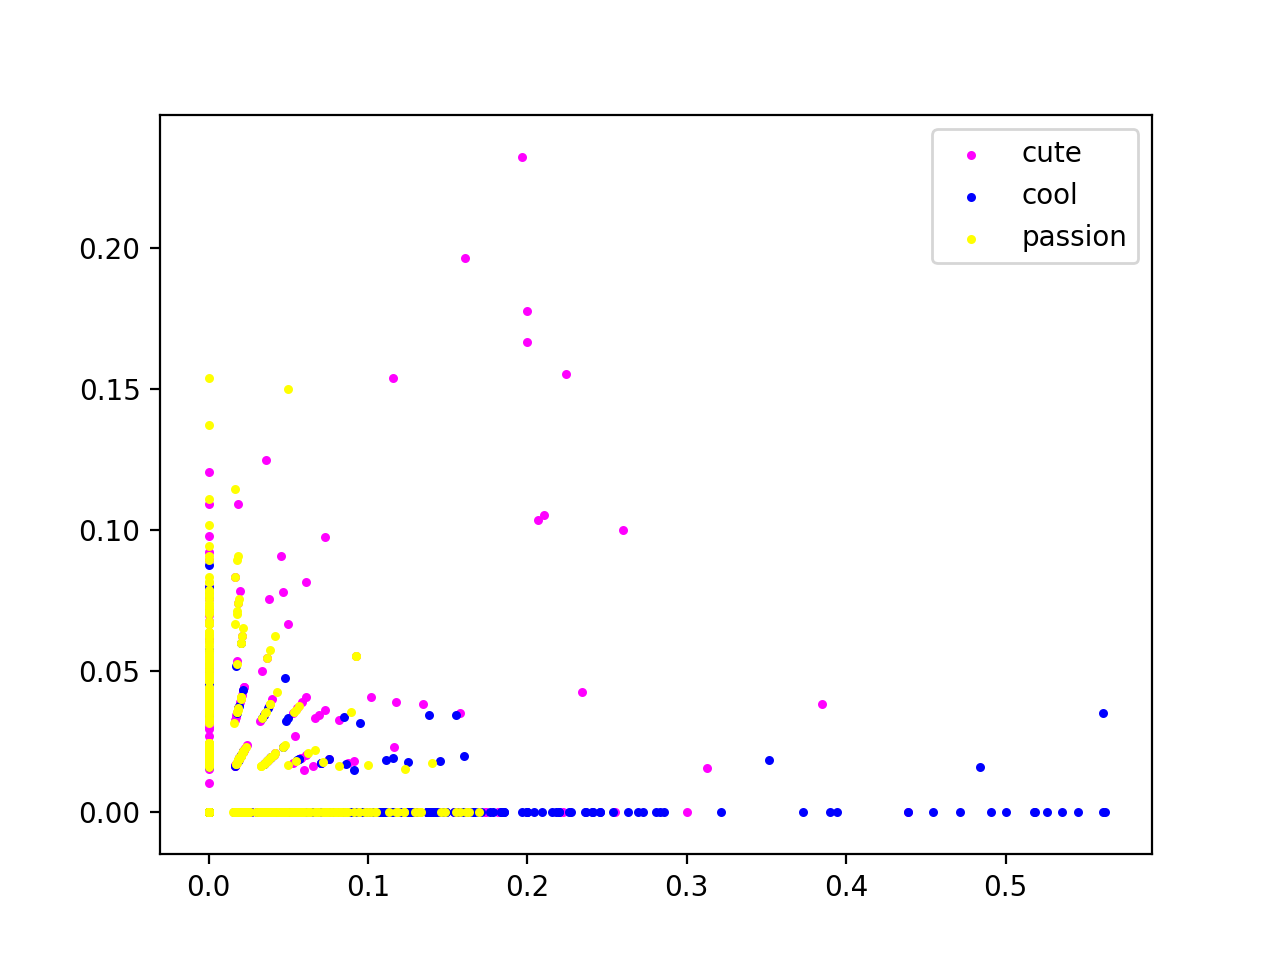

In [3]:
colors = {"cute":"magenta","cool":"blue","passion":"yellow"}
from pylab import rcParams
for type_temp in types:
    plt.scatter(density[type_temp][:,0],density[type_temp][:,1],color = colors[type_temp],label = type_temp,s = 5.0)
plt.legend()

<IPython.core.display.Javascript object>


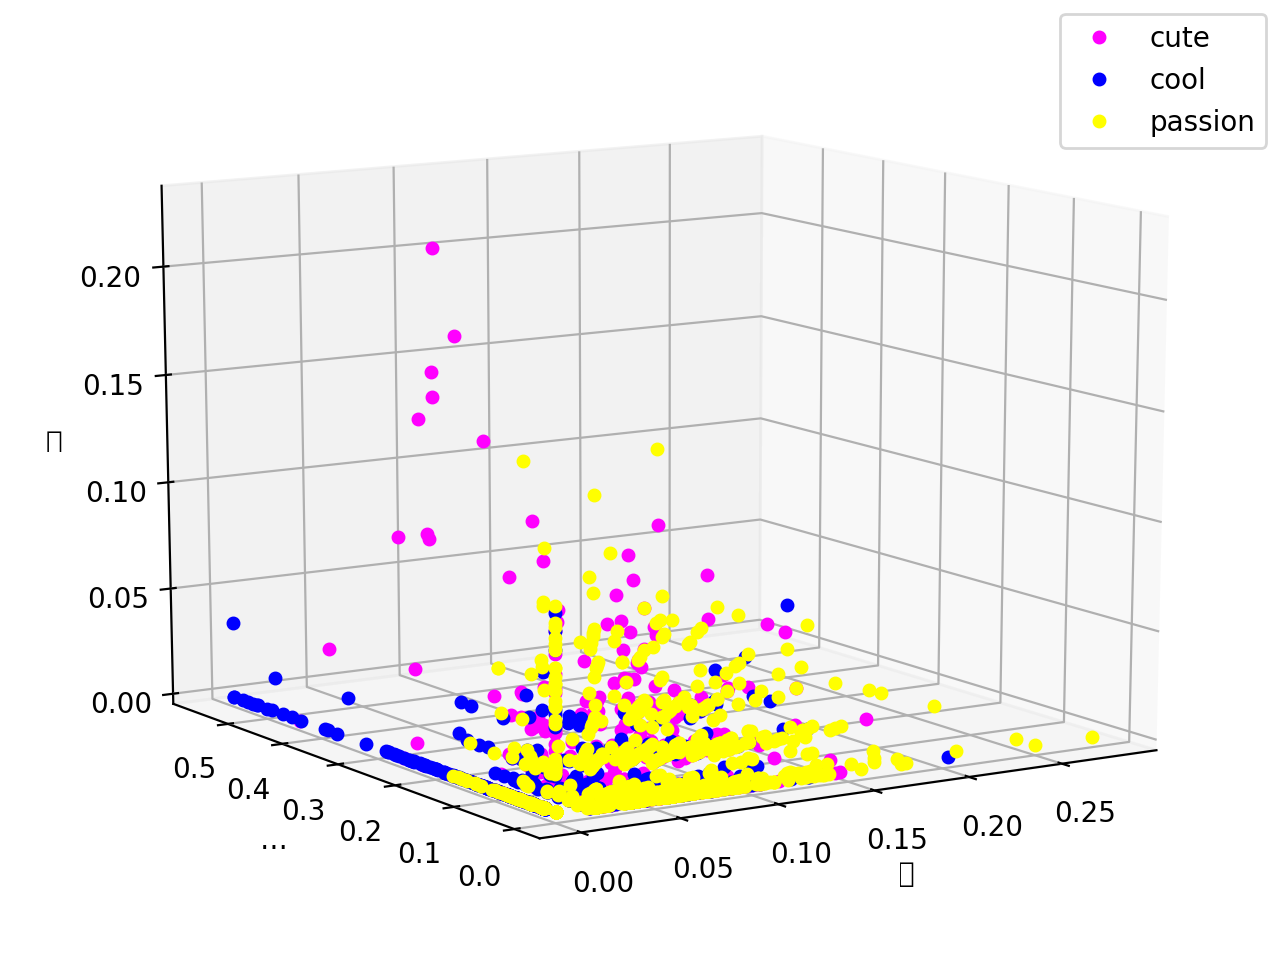

In [4]:
#3次元プロットするためのモジュール
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
#グラフの枠を作っていく
fig = plt.figure()
ax = Axes3D(fig)
#軸にラベルを付けたいときは書く
ax.set_xlabel(feature_words[0])
ax.set_ylabel(feature_words[1])
ax.set_zlabel(feature_words[2])
for type_temp in types:
    ax.plot(density[type_temp][:,0],density[type_temp][:,1],density[type_temp][:,2],marker = "o",color = colors[type_temp],label = type_temp,linestyle = "None",ms = 4)
plt.legend()
plt.savefig("feature.jpg")

In [7]:
import sklearn.model_selection
densities = []
target = []
for type_temp in types:
    for density_temp in density[type_temp]:
        densities.append(density_temp)
        target.append(type_temp)
densities = np.array(densities)
target = np.array(target)
print(densities)
print(target)
print(len(densities),len(target))
train_x, test_x, train_y, test_y = sklearn.model_selection.train_test_split(densities, target, test_size=0.2)
import sklearn.ensemble
model = sklearn.ensemble.RandomForestClassifier()
model.fit(train_x, train_y)

[[0.05555556 0.         0.         0.02777778]
 [0.03030303 0.         0.         0.03030303]
 [0.15555556 0.04444444 0.         0.        ]
 ...
 [0.03773585 0.03773585 0.         0.        ]
 [0.06521739 0.         0.         0.        ]
 [0.125      0.         0.         0.        ]]
['cute' 'cute' 'cute' ... 'passion' 'passion' 'passion']
2857 2857


C:\Users\yota-\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [8]:
accuracy = model.score(train_x,train_y)
print("train:accuracy {0:.2%}".format(accuracy))
accuracy = model.score(test_x,test_y)
print('test:accuracy {0:.2%}'.format(accuracy))

train:accuracy 76.63%
test:accuracy 48.95%


<IPython.core.display.Javascript object>


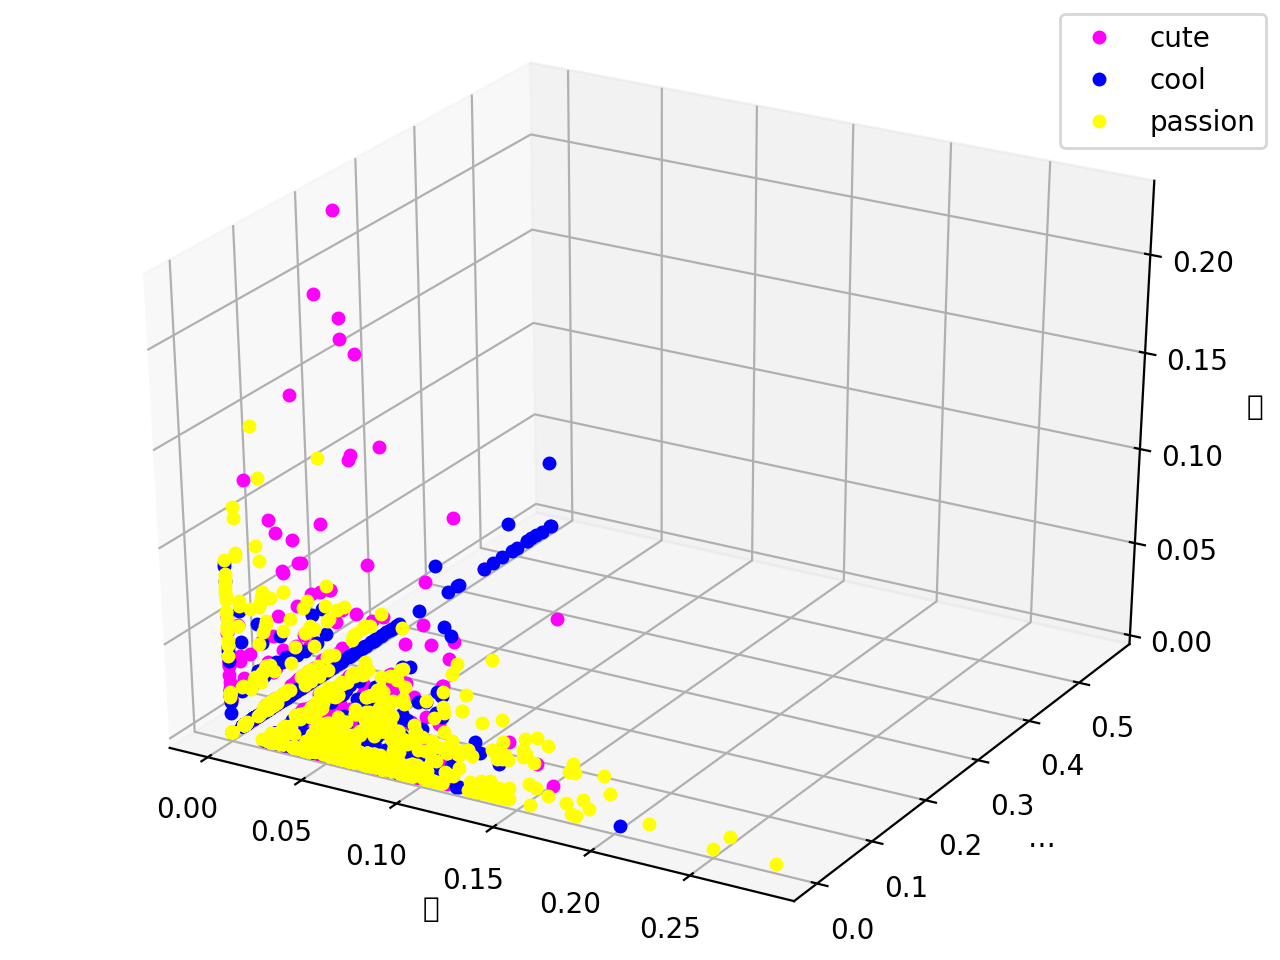

In [7]:
predictions = rf.predict(densities)
#3次元プロットするためのモジュール
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
#グラフの枠を作っていく
fig = plt.figure()
ax = Axes3D(fig)
#軸にラベルを付けたいときは書く
ax.set_xlabel(feature_words[0])
ax.set_ylabel(feature_words[1])
ax.set_zlabel(feature_words[2])
densities_pred = {}
for type_temp in types:
    densities_pred[type_temp] = []
    for i in range(len(predictions)):
        if predictions[i] == type_temp:
            densities_pred[type_temp].append(np.array(densities[i]))
    densities_pred[type_temp] = np.array(densities_pred[type_temp])
#print(densities_pred)
for type_temp in types:
    ax.plot(densities_pred[type_temp][:,0],densities_pred[type_temp][:,1],densities_pred[type_temp][:,2],marker = "o",color = colors[type_temp],label = type_temp,linestyle = "None",ms = 4)
plt.legend()
    

In [8]:
print(predictions)
print(densities)

['cute' 'cute' 'cute' ... 'passion' 'passion' 'passion']
[[0.05555556 0.         0.         0.02777778]
 [0.03030303 0.         0.         0.03030303]
 [0.15555556 0.04444444 0.         0.        ]
 ...
 [0.03773585 0.03773585 0.         0.        ]
 [0.06521739 0.         0.         0.        ]
 [0.125      0.         0.         0.        ]]


In [9]:
from sklearn.svm import SVC
model = SVC(kernel = "linear")
model.fit(train_x,train_y)
accuracy = model.score(train_x,train_y)
print("train:accuracy {0:.2%}".format(accuracy))
accuracy = model.score(test_x,test_y)
print('test:accuracy {0:.2%}'.format(accuracy))

train:accuracy 45.91%
test:accuracy 44.93%
